<a href="https://colab.research.google.com/github/shaoni11/Coursera_Capstone/blob/master/ML_case_study_census_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Case Study

Business problem:
Predict whether income of an individual exceeds $50K/per year based on census data.
Data source: http://archive.ics.uci.edu/ml/datasets/Adult 

Full Analysis : Jupyter Notebook

Python Packages used:
1. Pandas
2. Numpy
3. Pandas_profiling
4. Matplotlib
5. Seaborn
6. Sklearn

Classification Models Used:
1. Logistic Regression
2. Random Forest Classifier

Import the Libraries

In [ ]:
#!pip install pandas_profiling --upgrade

In [ ]:
import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport
import numpy as np
import missingno as msno
pd.set_option("display.max_columns", 100)

# Importing visualization packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import f1_score, classification_report
import warnings
import requests
warnings.filterwarnings("ignore")
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
pd.set_option('display.max_columns', 500)

Loading the dataset

In [ ]:
columns = ('age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income')
test = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test", names= columns, na_values=[' ?','?'])
train = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",  names= columns, na_values=[' ?','?'])

In [ ]:
test.head(3)

age workclass    fnlwgt education  education-num  \
0  |1x3 Cross validator       NaN       NaN       NaN            NaN   
1                    25   Private  226802.0      11th            7.0   
2                    38   Private   89814.0   HS-grad            9.0   

        marital-status          occupation relationship    race    sex  \
0                  NaN                 NaN          NaN     NaN    NaN   
1        Never-married   Machine-op-inspct    Own-child   Black   Male   
2   Married-civ-spouse     Farming-fishing      Husband   White   Male   

   capital-gain  capital-loss  hours-per-week  native-country   income  
0           NaN           NaN             NaN             NaN      NaN  
1           0.0           0.0            40.0   United-States   <=50K.  
2           0.0           0.0            50.0   United-States   <=50K.

In [ ]:
#drop row for index position 0 as its a garbage value
test.drop(test.index[[0]], inplace = True)

In [ ]:
#List columns of dataframe
train.columns
#len(train.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

We need to drop index column from test dataset

In [ ]:
test.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

Checking datatypes for the columns in the dataframe

In [ ]:
train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

In [ ]:
test.dtypes

age                object
workclass          object
fnlwgt            float64
education          object
education-num     float64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain      float64
capital-loss      float64
hours-per-week    float64
native-country     object
income             object
dtype: object

In [ ]:
#Assign NaN to all '?' in both the dataframe
train[train == ' ?'] = np.nan
test[test == ' ?'] = np.nan

### **Data preparation**

1. Performed Pandas profiling on the dataset as one stop solution for EDA techniques. It helps us to get an understanding of the data.

In [ ]:
profile = ProfileReport(train)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From the report , we found that we have multiple highly correlated columns in our dataset. We have 4262(0.9%) missing data in our dataset which needs to be taken care of, otherwise it will have impact on the performance of the model. 
Again, we have observed 22 (0.1%) duplicate data which we need to handle. 

Following columns have missing data:
1. workclass has 1836 (5.6%) missing values	
2. occupation has 1843 (5.7%) missing values
3. native-country has 583 (1.8%) missing values	

As all the columns have datatype as "Object", so we will replace missing values with mode. This is because , we replace missing values of categorical variables with Mode value usually.

Plotting variables to checking skewing

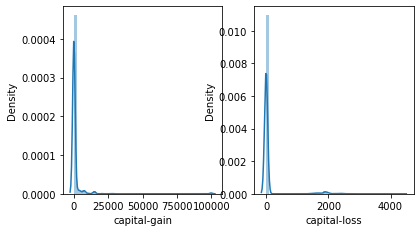

In [ ]:
# plot the histogram of a variable from the dataset to see the skewness
names= ['capital-gain','capital-loss']

plt.figure(figsize=(20,20))
i=0
for col in names:
    i += 1
    plt.subplot(5,6, i)
    sns.distplot(train[col])

plt.show()

2. Cleaning the datasets

Again, as we have observed multicollinearity in our dataframe, we decided to drop columns like "relationship", "race", "education".

In [ ]:
# Drop the 'relationship','race' and 'education' columns in both training & testing data
train.drop(['relationship', 'race','education'], axis='columns', inplace=True)
test.drop(['relationship', 'race','education'], axis='columns', inplace=True)

In [ ]:
# As the attributes with are categorical so imputing the missing value with mode operation
for i in [col for col in train.columns if train[col].isnull().any()]:
    train[i].fillna(train[i].mode()[0],inplace = True)
for i in [col for col in test.columns if test[col].isnull().any()] :
    test[i].fillna(test[i].mode()[0],inplace = True)

In [ ]:
#Cross-check once if we still have missing values
print("Missing values in training set : \n", train.isnull().sum())
print("\n")
print("Missing values in test set : \n", test.isnull().sum())

Missing values in training set : 
 age               0
workclass         0
fnlwgt            0
education-num     0
marital-status    0
occupation        0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


Missing values in test set : 
 age               0
workclass         0
fnlwgt            0
education-num     0
marital-status    0
occupation        0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


3. Drop duplicate values

In [ ]:
train = train.drop_duplicates()
test = test.drop_duplicates()

In [ ]:
train.describe()

age        fnlwgt  education-num  capital-gain  capital-loss  \
count  32531.000000  3.253100e+04   32531.000000  32531.000000  32531.000000   
mean      38.588331  1.897882e+05      10.081953   1078.642649     87.384341   
std       13.637685  1.055642e+05       2.571842   7388.624210    403.137260   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178150e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783700e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370190e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    32531.000000  
mean        40.441025  
std         12.347506  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000

Applying Label Encoding for handling categorical Values. WE dont want to increase dimensions in the dataset, hence going for Label Encoding rather than One-Hot Encoding

In [ ]:
test['age'] = pd.to_numeric(test['age'])##, errors='coerce')

encoder = LabelEncoder()
#Encoding training & testing data
for i in train.columns: # Make a for loops
    if train[i].dtype == 'object': 
        encoder.fit(list(train[i].values)) # Fit transform
        train[i] = encoder.transform(train[i].values) # Transform
         
        for j in train.columns: # Make a for loops again
            if train[j].dtype == 'int64':
                train[j] = train[j].astype('float64') # Change the type

for i in test.columns: # Make a for loops
    if test[i].dtype == 'object': 
        encoder.fit(list(test[i].values)) # Fit transform
        test[i] = encoder.transform(test[i].values) # Transform

for j in test.columns: # Make a for loops again
            if test[j].dtype == 'int64':
                test[j] = test[j].astype('float64') # Change the type

In [ ]:
train['income'].value_counts()

0.0    24692
1.0     7839
Name: income, dtype: int64

Column Income has been labelled as:

Class 0 = "<=50K"
Class 1 = ">50K"

It has been observed from the above count, that it is a problem of imbalanced class. 

As a part of model building, I would like to approach in 2 different ways.
First, I want to create a base model on the unbalanced & unscaled data 

Then, I will scale the data & build models using below sampling technique:
1. Random Oversampling
2. SMOTE

I will go for oversampling in dataset, as there is only 32561 data samples available in the dataset. So if I take an approach of undersampling I will loose data-points, leading to fewer observations in the dataset. This will effect in model building. 

### **Splitting the data into train & test data**

In [ ]:
y= train.income
X = train.drop("income", axis = 1)

In [ ]:
X.columns

Index(['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status',
       'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
       'native-country'],
      dtype='object')

In [ ]:
y_test = test.income
X_test = test.drop("income", axis = 1)


In [ ]:
X_test.columns

Index(['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status',
       'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
       'native-country'],
      dtype='object')

In [ ]:
# Spltting the into 80:20 train test size
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 42)

## Model Building

As a part of model building, I will train my model with below algorithms:

1. Logistic Classification
2. Random Forest Classification



### 1. Logistic Classification on unbalanced & unscaled data

I have applied L2 regularization in my Logistic Regression model for reducing the standard error in my model. Also, I have used GridSearchCV for hyperparameter tuning.

In [ ]:
# Logistic Regression parameters for K-fold cross vaidation
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}
folds = KFold(n_splits=5, shuffle=True, random_state=4)


#perform cross validation
model_lr = GridSearchCV(estimator = LogisticRegression(penalty = 'l2', dual = False, tol = 1e-4, fit_intercept = True, solver = 'liblinear'),
                        param_grid = params, 
                        cv = folds, 
                        n_jobs=-1,
                        verbose = 1,
                        return_train_score=True) 
#perform hyperparameter tuning
#model_cv = LogisticRegression(penalty = 'l2', dual = False, tol = 1e-4, fit_intercept = True, solver = 'liblinear')
model_lr.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, verbose=1)

In [ ]:
y_pred = model_lr.predict(X_val)

In [ ]:
y_test_pred = model_lr.predict(X_test)

In [ ]:
print(f"F1 Score: {round(f1_score(y_val, y_pred)*100,2)}%") 
print(f"Classification Report: \n {classification_report(y_val, y_pred)}")


print(f"F1 Score: {round(f1_score(y_test, y_test_pred)*100,2)}%") 
print(f"Classification Report: \n {classification_report(y_test, y_test_pred)}")

print(f"Accuracy on Validation: {round(accuracy_score(y_val, y_pred)*100,2)}%")
print(f"Accuracy on test set: {round(accuracy_score(y_test, y_test_pred)*100,2)}%")

F1 Score: 39.45%
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.81      0.95      0.87      4947
         1.0       0.63      0.29      0.39      1560

    accuracy                           0.79      6507
   macro avg       0.72      0.62      0.63      6507
weighted avg       0.77      0.79      0.76      6507

F1 Score: 40.41%
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.81      0.94      0.87     12429
         1.0       0.62      0.30      0.40      3846

    accuracy                           0.79     16275
   macro avg       0.71      0.62      0.64     16275
weighted avg       0.77      0.79      0.76     16275

Accuracy on Validation: 78.92%
Accuracy on test set: 79.05%


As per the classfication report, accuracy is almost same in both training & testing dataset. The accuracy for my basemodel using Logistic Regression is ~79%.

I will scale the date & apply oversampling on the dataset & will train the model again.

2. Applying Random Forest Classifier in unscaled & unbalanced data

In [ ]:
# Building and fitting Random Forest
model3=RandomForestClassifier(max_depth = 30,
                                min_samples_split=2, 
                                n_estimators =200,random_state = 2022)
grid = {'n_estimators': [200,700,1000],'max_depth': [None,10,15,13]}
model_rf=GridSearchCV(estimator=model3,param_grid=grid,cv=5,n_jobs=-1,verbose=100)

In [ ]:
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_val)
y_test_RFpred = model_rf.predict(X_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
print(f"F1 Score: {round(f1_score(y_val, y_pred_rf)*100,2)}%") 
print(f"Classification Report: \n {classification_report(y_val, y_pred_rf)}")

print(f"F1 Score: {round(f1_score(y_test, y_test_RFpred)*100,2)}%") 
print(f"Classification Report: \n {classification_report(y_test, y_test_RFpred)}")

print(f"Accuracy on Validation: {round(accuracy_score(y_val, y_pred_rf)*100,2)}%")
print(f"Accuracy on test set: {round(accuracy_score(y_test, y_test_RFpred)*100,2)}%")

F1 Score: 68.19%
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.88      0.95      0.91      4947
         1.0       0.78      0.60      0.68      1560

    accuracy                           0.86      6507
   macro avg       0.83      0.78      0.80      6507
weighted avg       0.86      0.86      0.86      6507

F1 Score: 66.95%
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.88      0.95      0.91     12429
         1.0       0.78      0.59      0.67      3846

    accuracy                           0.86     16275
   macro avg       0.83      0.77      0.79     16275
weighted avg       0.86      0.86      0.86     16275

Accuracy on Validation: 86.49%
Accuracy on test set: 86.33%


The base model for RF Classifier is showing an excellent accuracy of ~86% in both train & test data.

## Normalizing dataset

I will perform scaling on numerical features. As applying scaling ensures that each feature is treated equally when applying supervised learners.

In [ ]:
# Standarscaler
scaler = StandardScaler()

#Minmax Scaler
#scaler = MinMaxScaler()
# all columns to all_cols
all_cols = X.columns
#col = y.column

# fit scaler
X_scaled = scaler.fit_transform(X[all_cols])
print("X_scaled shape:", X_scaled.shape)

X_scaled shape: (32531, 11)


In [ ]:
# Spltting the into 80:20 train test size
X_train_scaled, X_val_scaled, y_train, y_val_ = train_test_split(X_scaled, y, test_size=0.2, random_state = 42)
X_train_scaled.shape

(26024, 11)

In [ ]:
X_test_scaled = scaler.fit_transform(test[all_cols])
X_test.shape

(16275, 11)

# 1. Random Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_random, y_random = oversample.fit_resample(X_train_scaled, y_train)

Applying Logistic Regression on Random oversampled data

In [ ]:
#perform hyperparameter tuning
model_lr.fit(X_random, y_random)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, verbose=1)

In [ ]:
y_pred_random = model_lr.predict(X_val_scaled)
y_test_pred_lr = model_lr.predict(X_test_scaled)

In [ ]:
print(f"F1 Score: {round(f1_score(y_val, y_pred_random)*100,2)}%") 
print(f"Classification Report: \n {classification_report(y_val, y_pred_random)}")


print(f"F1 Score: {round(f1_score(y_test, y_test_pred_lr)*100,2)}%") 
print(f"Classification Report: \n {classification_report(y_test, y_test_pred_lr)}")

print(f"Accuracy on Validation: {round(accuracy_score(y_val, y_pred_random)*100,2)}%")
print(f"Accuracy on test set: {round(accuracy_score(y_test, y_test_pred_lr)*100,2)}%")

F1 Score: 61.1%
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.91      0.77      0.83      4947
         1.0       0.51      0.76      0.61      1560

    accuracy                           0.77      6507
   macro avg       0.71      0.77      0.72      6507
weighted avg       0.82      0.77      0.78      6507

F1 Score: 59.69%
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.91      0.76      0.83     12429
         1.0       0.49      0.76      0.60      3846

    accuracy                           0.76     16275
   macro avg       0.70      0.76      0.71     16275
weighted avg       0.81      0.76      0.77     16275

Accuracy on Validation: 76.72%
Accuracy on test set: 75.9%


As observed, accuracy has decreased in Logistic Regression on scaled & oversampled data. It has dropped from ~79% to ~76%. My logistic Regression basemodel is performing good so far. 

Applying Random Forest on randomly oversampled dataset

In [ ]:
model_rf.fit(X_random,y_random)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=30, n_estimators=200,
                                              random_state=2022),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 15, 13],
                         'n_estimators': [200, 700, 1000]},
             verbose=100)

In [ ]:
y_pred_RF = model_rf.predict(X_val_scaled)
y_test_scaled_RF = model_rf.predict(X_test_scaled)

In [ ]:
print(f"F1 Score: {round(f1_score(y_val, y_pred_RF)*100,2)}%") 
print(f"Classification Report: \n {classification_report(y_val, y_pred_RF)}")


print(f"F1 Score: {round(f1_score(y_test, y_test_scaled_RF)*100,2)}%") 
print(f"Classification Report: \n {classification_report(y_test, y_test_scaled_RF)}")

print(f"Accuracy on Validation: {round(accuracy_score(y_val, y_pred_RF)*100,2)}%")
print(f"Accuracy on test set: {round(accuracy_score(y_test, y_test_scaled_RF)*100,2)}%")

F1 Score: 68.52%
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.90      0.90      0.90      4947
         1.0       0.68      0.69      0.69      1560

    accuracy                           0.85      6507
   macro avg       0.79      0.79      0.79      6507
weighted avg       0.85      0.85      0.85      6507

F1 Score: 66.9%
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.90      0.90      0.90     12429
         1.0       0.67      0.66      0.67      3846

    accuracy                           0.84     16275
   macro avg       0.79      0.78      0.78     16275
weighted avg       0.84      0.84      0.84     16275

Accuracy on Validation: 84.88%
Accuracy on test set: 84.49%


With Random oversampling, accuracy dropped for RandomForest as well from ~86% to ~84%. The precision has inreased for Class 0 from 0.88 to 0.90, keeping precision for class 1 almost same. Though accuracy has dropped minutely, but the model is doing good, as we have little improvement in precision value of the model.

## 2. Applying SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)
X_train_smote, y_train_smote = sm.fit_resample(X_train_scaled, y_train)

Applying Logistic Regression on SMOTE oversampled data

In [ ]:
#train LR model 
model_lr.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, verbose=1)

In [ ]:
y_pred_smote = model_lr.predict(X_val_scaled)
y_pred_test_smote = model_lr.predict(X_test_scaled)

In [ ]:
print(f"F1 Score: {round(f1_score(y_val, y_pred_smote)*100,2)}%") 
print(f"Classification Report: \n {classification_report(y_val, y_pred_smote)}")

print(f"F1 Score: {round(f1_score(y_test, y_pred_test_smote)*100,2)}%") 
print(f"Classification Report: \n {classification_report(y_test, y_pred_test_smote)}")

print(f"Accuracy on Validation: {round(accuracy_score(y_val, y_pred_smote)*100,2)}%")
print(f"Accuracy on test set: {round(accuracy_score(y_test, y_pred_test_smote)*100,2)}%")

F1 Score: 61.02%
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.91      0.77      0.83      4947
         1.0       0.51      0.77      0.61      1560

    accuracy                           0.77      6507
   macro avg       0.71      0.77      0.72      6507
weighted avg       0.81      0.77      0.78      6507

F1 Score: 59.6%
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.91      0.76      0.83     12429
         1.0       0.49      0.76      0.60      3846

    accuracy                           0.76     16275
   macro avg       0.70      0.76      0.71     16275
weighted avg       0.81      0.76      0.77     16275

Accuracy on Validation: 76.53%
Accuracy on test set: 75.75%


Ther is no improvement in model evaluation with SMOTE oversampling in Logistic Regression. Accuracy is almost constant as RandomOversampling. Precision & recall value has not dropped as well. So, there is no impact with this model & can drop off with SMOTE.

Applying Random Forest on SMOTE oversampled data

In [ ]:
# fit the model
model_rf.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=30, n_estimators=200,
                                              random_state=2022),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 15, 13],
                         'n_estimators': [200, 700, 1000]},
             verbose=100)

In [ ]:
y_rf_pred_smote = model_rf.predict(X_val_scaled)

In [ ]:
y_test_pred_rf = model_rf.predict(X_test_scaled)

In [ ]:
print(f"F1 Score: {round(f1_score(y_val, y_rf_pred_smote)*100,2)}%") 
print(f"Classification Report: \n {classification_report(y_val, y_rf_pred_smote)}")

print(f"F1 Score: {round(f1_score(y_test, y_test_pred_rf)*100,2)}%") 
print(f"Classification Report: \n {classification_report(y_test, y_test_pred_rf)}")

print(f"Accuracy on Validation: {round(accuracy_score(y_val, y_rf_pred_smote)*100,2)}%")
print(f"Accuracy on test set: {round(accuracy_score(y_test, y_test_pred_rf)*100,2)}%")

F1 Score: 67.92%
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.90      0.90      0.90      4947
         1.0       0.67      0.68      0.68      1560

    accuracy                           0.85      6507
   macro avg       0.79      0.79      0.79      6507
weighted avg       0.85      0.85      0.85      6507

F1 Score: 57.45%
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.60      0.74     12429
         1.0       0.42      0.93      0.57      3846

    accuracy                           0.68     16275
   macro avg       0.69      0.76      0.66     16275
weighted avg       0.83      0.68      0.70     16275

Accuracy on Validation: 84.51%
Accuracy on test set: 67.61%


There is a huge fall in test set accuracy with SMOTE oversampling. This can be a case of Overfitting in this model. Therefore, I can reject this model of Random Forest with SMOTE oversampling.

## Evaluation Metrics

In our model, we have focused on below metrics for evaluating my model perfoemance:

**Accuracy** is ratio of the number of correct predictions to the total number of predictions.

**Precision** tells of true positives.

[True Positives/(True Positives + False Positives)]

**Recall(sensitivity)** tells us what proportion of data that actually were Class 1, and were classified by us as Class 1. 

[True Positives/(True Positives + False Negatives)]

For classification problems that are skewed in their classification distributions like in this usecase, accuracy by itself is not a very good metric. For this use-case, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. F1- score ranges from 0 to 1.

# Conclusion

I choose Random Forest model with Random Oversampling as my preferred my approach. The model has good accuracy, as well as improved precision and recall value of all the models developed as a part of this analysis. The advantages of using Random Forest over other models is that it can overcome the cons of overfitting. Also, it can handle outliers in the dataset & scale them by essentially binning them. So, it will reduce the effort of handling outliers outside the model. Also, as per model structure, Random Forest performs validation test while training the model itself.